In [ ]:
pip install basemap

In [ ]:
import pandas as pd
import random as rn
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.animation import FuncAnimation
from mpl_toolkits.basemap import Basemap
import warnings


In [ ]:
df = pd.read_csv("matriz_costo.csv", sep=",")
df

,Ciudades,Palmira,Pasto,Tuluá,Bogotá,Pereira,Armenia,Manizales,Valledupar,Montería,Soledad,Cartagena,Barranquilla,Medellín,Bucaramanga,Cúcuta
0,Palmira,0,370771,84087,447589,191343,169457,258331,972957,823383,1092471,1021736,1095146,411104,695655,890631
1,Pasto,376387,0,424690,786902,549052,509329,595600,1343992,1156632,1391877,1356516,1442348,762412,1035828,1212875
2,Tuluá,83412,432054,0,442290,110914,109122,191483,909514,726411,988052,958935,1188245,341146,790521,821859
3,Bogotá,461204,808938,378876,0,366907,293665,297425,740924,777965,873740,901263,877782,424634,411334,506174
4,Pereira,192609,539679,110748,326691,0,53793,81643,789260,628239,878991,849071,950005,235782,513758,704063
5,Armenia,159650,516330,87357,280726,52709,0,132677,802756,680688,937326,871684,946588,288429,524931,714437
6,Manizales,257384,602633,185932,295734,82146,133107,0,725709,603052,853970,816286,870598,201619,448578,639018
7,Valledupar,991737,1355916,909076,753356,779047,815892,727233,0,376219,270061,329666,284014,667483,390368,458759
8,Montería,815181,1065383,717564,802481,662374,712863,624590,379643,0,298020,262358,318500,404322,522283,587810
9,Soledad,1131745,1478110,1049717,875658,944821,946933,857807,268297,320594,0,123001,16198,663815,521046,589001


In [ ]:
df = df.copy()
df = df.drop(df.columns[0], axis=1)

In [ ]:
matriz = df.values.tolist()

In [ ]:
#Tomado de https://github.com/johnberroa/Ant-Colony-Optimization
warnings.filterwarnings("ignore")


class AntColonyOptimizer:
    def __init__(self, ants, evaporation_rate, intensification, alpha=1.0, beta=0.0, beta_evaporation_rate=0,
                 choose_best=.1):
        """
        Ant colony optimizer.  Traverses a graph and finds either the max or min distance between nodes.
        :param ants: number of ants to traverse the graph
        :param evaporation_rate: rate at which pheromone evaporates
        :param intensification: constant added to the best path
        :param alpha: weighting of pheromone
        :param beta: weighting of heuristic (1/distance)
        :param beta_evaporation_rate: rate at which beta decays (optional)
        :param choose_best: probability to choose the best route
        """
        # Parameters
        self.ants = ants
        self.evaporation_rate = evaporation_rate
        self.pheromone_intensification = intensification
        self.heuristic_alpha = alpha
        self.heuristic_beta = beta
        self.beta_evaporation_rate = beta_evaporation_rate
        self.choose_best = choose_best

        # Internal representations
        self.pheromone_matrix = None
        self.heuristic_matrix = None
        self.probability_matrix = None

        self.map = None
        self.set_of_available_nodes = None

        # Internal stats
        self.best_series = []
        self.best = None
        self.fitted = False
        self.best_path = None
        self.fit_time = None

        # Plotting values
        self.stopped_early = False

    def __str__(self):
        string = "Ant Colony Optimizer"
        string += "\n--------------------"
        string += "\nDesigned to optimize either the minimum or maximum distance between nodes in a square matrix that behaves like a distance matrix."
        string += "\n--------------------"
        string += "\nNumber of ants:\t\t\t\t{}".format(self.ants)
        string += "\nEvaporation rate:\t\t\t{}".format(self.evaporation_rate)
        string += "\nIntensification factor:\t\t{}".format(self.pheromone_intensification)
        string += "\nAlpha Heuristic:\t\t\t{}".format(self.heuristic_alpha)
        string += "\nBeta Heuristic:\t\t\t\t{}".format(self.heuristic_beta)
        string += "\nBeta Evaporation Rate:\t\t{}".format(self.beta_evaporation_rate)
        string += "\nChoose Best Percentage:\t\t{}".format(self.choose_best)
        string += "\n--------------------"
        string += "\nUSAGE:"
        string += "\nNumber of ants influences how many paths are explored each iteration."
        string += "\nThe alpha and beta heuristics affect how much influence the pheromones or the distance heuristic weigh an ants' decisions."
        string += "\nBeta evaporation reduces the influence of the heuristic over time."
        string += "\nChoose best is a percentage of how often an ant will choose the best route over probabilistically choosing a route based on pheromones."
        string += "\n--------------------"
        if self.fitted:
            string += "\n\nThis optimizer has been fitted."
        else:
            string += "\n\nThis optimizer has NOT been fitted."
        return string

    def _initialize(self):
        """
        Initializes the model by creating the various matrices and generating the list of available nodes
        """
        assert self.map.shape[0] == self.map.shape[1], "Map is not a distance matrix!"
        num_nodes = self.map.shape[0]
        self.pheromone_matrix = np.ones((num_nodes, num_nodes))
        # Remove the diagonal since there is no pheromone from node i to itself
        self.pheromone_matrix[np.eye(num_nodes) == 1] = 0
        self.heuristic_matrix = 1 / self.map
        self.probability_matrix = (self.pheromone_matrix ** self.heuristic_alpha) * (
                self.heuristic_matrix ** self.heuristic_beta)  # element by element multiplcation
        self.set_of_available_nodes = list(range(num_nodes))

    def _reinstate_nodes(self):
        """
        Resets available nodes to all nodes for the next iteration
        """
        self.set_of_available_nodes = list(range(self.map.shape[0]))

    def _update_probabilities(self):
        """
        After evaporation and intensification, the probability matrix needs to be updated.  This function
        does that.
        """
        self.probability_matrix = (self.pheromone_matrix ** self.heuristic_alpha) * (
                self.heuristic_matrix ** self.heuristic_beta)

    def _choose_next_node(self, from_node):
        """
        Chooses the next node based on probabilities.  If p < p_choose_best, then the best path is chosen, otherwise
        it is selected from a probability distribution weighted by the pheromone.
        :param from_node: the node the ant is coming from
        :return: index of the node the ant is going to
        """
        numerator = self.probability_matrix[from_node, self.set_of_available_nodes]
        if np.random.random() < self.choose_best:
            next_node = np.argmax(numerator)
        else:
            denominator = np.sum(numerator)
            probabilities = numerator / denominator
            next_node = np.random.choice(range(len(probabilities)), p=probabilities)
        return next_node

    def _remove_node(self, node):
        self.set_of_available_nodes.remove(node)

    def _evaluate(self, paths, mode):
        """
        Evaluates the solutions of the ants by adding up the distances between nodes.
        :param paths: solutions from the ants
        :param mode: max or min
        :return: x and y coordinates of the best path as a tuple, the best path, and the best score
        """
        scores = np.zeros(len(paths))
        coordinates_i = []
        coordinates_j = []
        for index, path in enumerate(paths):
            score = 0
            coords_i = []
            coords_j = []
            for i in range(len(path) - 1):
                coords_i.append(path[i])
                coords_j.append(path[i + 1])
                score += self.map[path[i], path[i + 1]]
            scores[index] = score
            coordinates_i.append(coords_i)
            coordinates_j.append(coords_j)
        if mode == 'min':
            best = np.argmin(scores)
        elif mode == 'max':
            best = np.argmax(scores)
        return (coordinates_i[best], coordinates_j[best]), paths[best], scores[best]

    def _evaporation(self):
        """
        Evaporate some pheromone as the inverse of the evaporation rate.  Also evaporates beta if desired.
        """
        self.pheromone_matrix *= (1 - self.evaporation_rate)
        self.heuristic_beta *= (1 - self.beta_evaporation_rate)

    def _intensify(self, best_coords):
        """
        Increases the pheromone by some scalar for the best route.
        :param best_coords: x and y (i and j) coordinates of the best route
        """
        i = best_coords[0]
        j = best_coords[1]
        self.pheromone_matrix[i, j] += self.pheromone_intensification

    def fit(self, map_matrix, iterations=100, mode='min', early_stopping_count=20, verbose=True):
        """
        Fits the ACO to a specific map.  This was designed with the Traveling Salesman problem in mind.
        :param map_matrix: Distance matrix or some other matrix with similar properties
        :param iterations: number of iterations
        :param mode: whether to get the minimum path or maximum path
        :param early_stopping_count: how many iterations of the same score to make the algorithm stop early
        :return: the best score
        """
        if verbose: print("Beginning ACO Optimization with {} iterations...".format(iterations))
        self.map = map_matrix
        start = time.time()
        self._initialize()
        num_equal = 0

        for i in range(iterations):
            start_iter = time.time()
            paths = []
            path = []

            for ant in range(self.ants):
                current_node = self.set_of_available_nodes[np.random.randint(0, len(self.set_of_available_nodes))]
                start_node = current_node
                while True:
                    path.append(current_node)
                    self._remove_node(current_node)
                    if len(self.set_of_available_nodes) != 0:
                        current_node_index = self._choose_next_node(current_node)
                        current_node = self.set_of_available_nodes[current_node_index]
                    else:
                        break

                path.append(start_node)  # go back to start
                self._reinstate_nodes()
                paths.append(path)
                path = []

            best_path_coords, best_path, best_score = self._evaluate(paths, mode)

            if i == 0:
                best_score_so_far = best_score
            else:
                if mode == 'min':
                    if best_score < best_score_so_far:
                        best_score_so_far = best_score
                        self.best_path = best_path
                elif mode == 'max':
                    if best_score > best_score_so_far:
                        best_score_so_far = best_score
                        self.best_path = best_path

            if best_score == best_score_so_far:
                num_equal += 1
            else:
                num_equal = 0

            self.best_series.append(best_score)
            self._evaporation()
            self._intensify(best_path_coords)
            self._update_probabilities()

            if verbose: print("Best score at iteration {}: {}; overall: {} ({}s)"
                              "".format(i, round(best_score, 2), round(best_score_so_far, 2),
                                        round(time.time() - start_iter)))

            if best_score == best_score_so_far and num_equal == early_stopping_count:
                self.stopped_early = True
                print("Stopping early due to {} iterations of the same score.".format(early_stopping_count))
                break

        self.fit_time = round(time.time() - start)
        self.fitted = True

        if mode == 'min':
            self.best = self.best_series[np.argmin(self.best_series)]
            if verbose: print(
                "ACO fitted.  Runtime: {} minutes.  Best score: {}".format(self.fit_time // 60, self.best))
            return self.best
        elif mode == 'max':
            self.best = self.best_series[np.argmax(self.best_series)]
            if verbose: print(
                "ACO fitted.  Runtime: {} minutes.  Best score: {}".format(self.fit_time // 60, self.best))
            return self.best
        else:
            raise ValueError("Invalid mode!  Choose 'min' or 'max'.")

    def plot(self):
        """
        Plots the score over time after the model has been fitted.
        :return: None if the model isn't fitted yet
        """
        if not self.fitted:
            print("Ant Colony Optimizer not fitted!  There exists nothing to plot.")
            return None
        else:
            fig, ax = plt.subplots(figsize=(20, 15))
            ax.plot(self.best_series, label="Best Run")
            ax.set_xlabel("Iteration")
            ax.set_ylabel("Performance")
            ax.text(.8, .6,
                    'Ants: {}\nEvap Rate: {}\nIntensify: {}\nAlpha: {}\nBeta: {}\nBeta Evap: {}\nChoose Best: {}\n\nFit Time: {}m{}'.format(
                        self.ants, self.evaporation_rate, self.pheromone_intensification, self.heuristic_alpha,
                        self.heuristic_beta, self.beta_evaporation_rate, self.choose_best, self.fit_time // 60,
                        ["\nStopped Early!" if self.stopped_early else ""][0]),
                    bbox={'facecolor': 'gray', 'alpha': 0.8, 'pad': 10}, transform=ax.transAxes)
            ax.legend()
            plt.title("Ant Colony Optimization Results (best: {})".format(np.round(self.best, 2)))
            plt.show()

#Matriz de costos
La matriz de costos se construyó mediante una serie de cálculos detallados que abarcaron distintos aspectos. En primer lugar, se consideró la distancia a recorrer, la cual se utilizó para calcular el costo de la gasolina consumida por el vehículo seleccionado, un Renault Logan. Según un estudio de Autolab (2022), este modelo puede alcanzar un consumo de gasolina que oscila entre los 12 y 16 kilómetros por litro, equivalente a aproximadamente 28 a 38 kilómetros por galón. Por ende, se tomó un valor medio para estimar la cantidad de galones necesarios, utilizando el precio del galón de gasolina colombiana, fijado en COP 15,416 pesos. Además, se evaluó el factor tiempo, el cual implicó el pago al conductor por su servicio. Se decidió abonarle el equivalente a tres veces el precio de la hora en Colombia, establecido en COP 5,532 pesos. A este costo total, se sumó el valor de los peajes en la ruta seleccionada, completando así una matriz integral de costos que abarca los diferentes aspectos implicados en el transporte.

In [ ]:
distances = np.array(matriz)
problem = distances

Beginning ACO Optimization with 100 iterations...
Best score at iteration 0: 4859001.0; overall: 4859001.0 (0s)
Best score at iteration 1: 4890197.0; overall: 4859001.0 (0s)
Best score at iteration 2: 4616952.0; overall: 4616952.0 (0s)
Best score at iteration 3: 4836050.0; overall: 4616952.0 (0s)
Best score at iteration 4: 4010460.0; overall: 4010460.0 (0s)
Best score at iteration 5: 4067079.0; overall: 4010460.0 (0s)
Best score at iteration 6: 4541148.0; overall: 4010460.0 (0s)
Best score at iteration 7: 4067079.0; overall: 4010460.0 (0s)
Best score at iteration 8: 4840967.0; overall: 4010460.0 (0s)
Best score at iteration 9: 4806502.0; overall: 4010460.0 (0s)
Best score at iteration 10: 3898486.0; overall: 3898486.0 (0s)
Best score at iteration 11: 4534536.0; overall: 3898486.0 (0s)
Best score at iteration 12: 3898486.0; overall: 3898486.0 (0s)
Best score at iteration 13: 4067079.0; overall: 3898486.0 (0s)
Best score at iteration 14: 4347711.0; overall: 3898486.0 (0s)
Best score at i

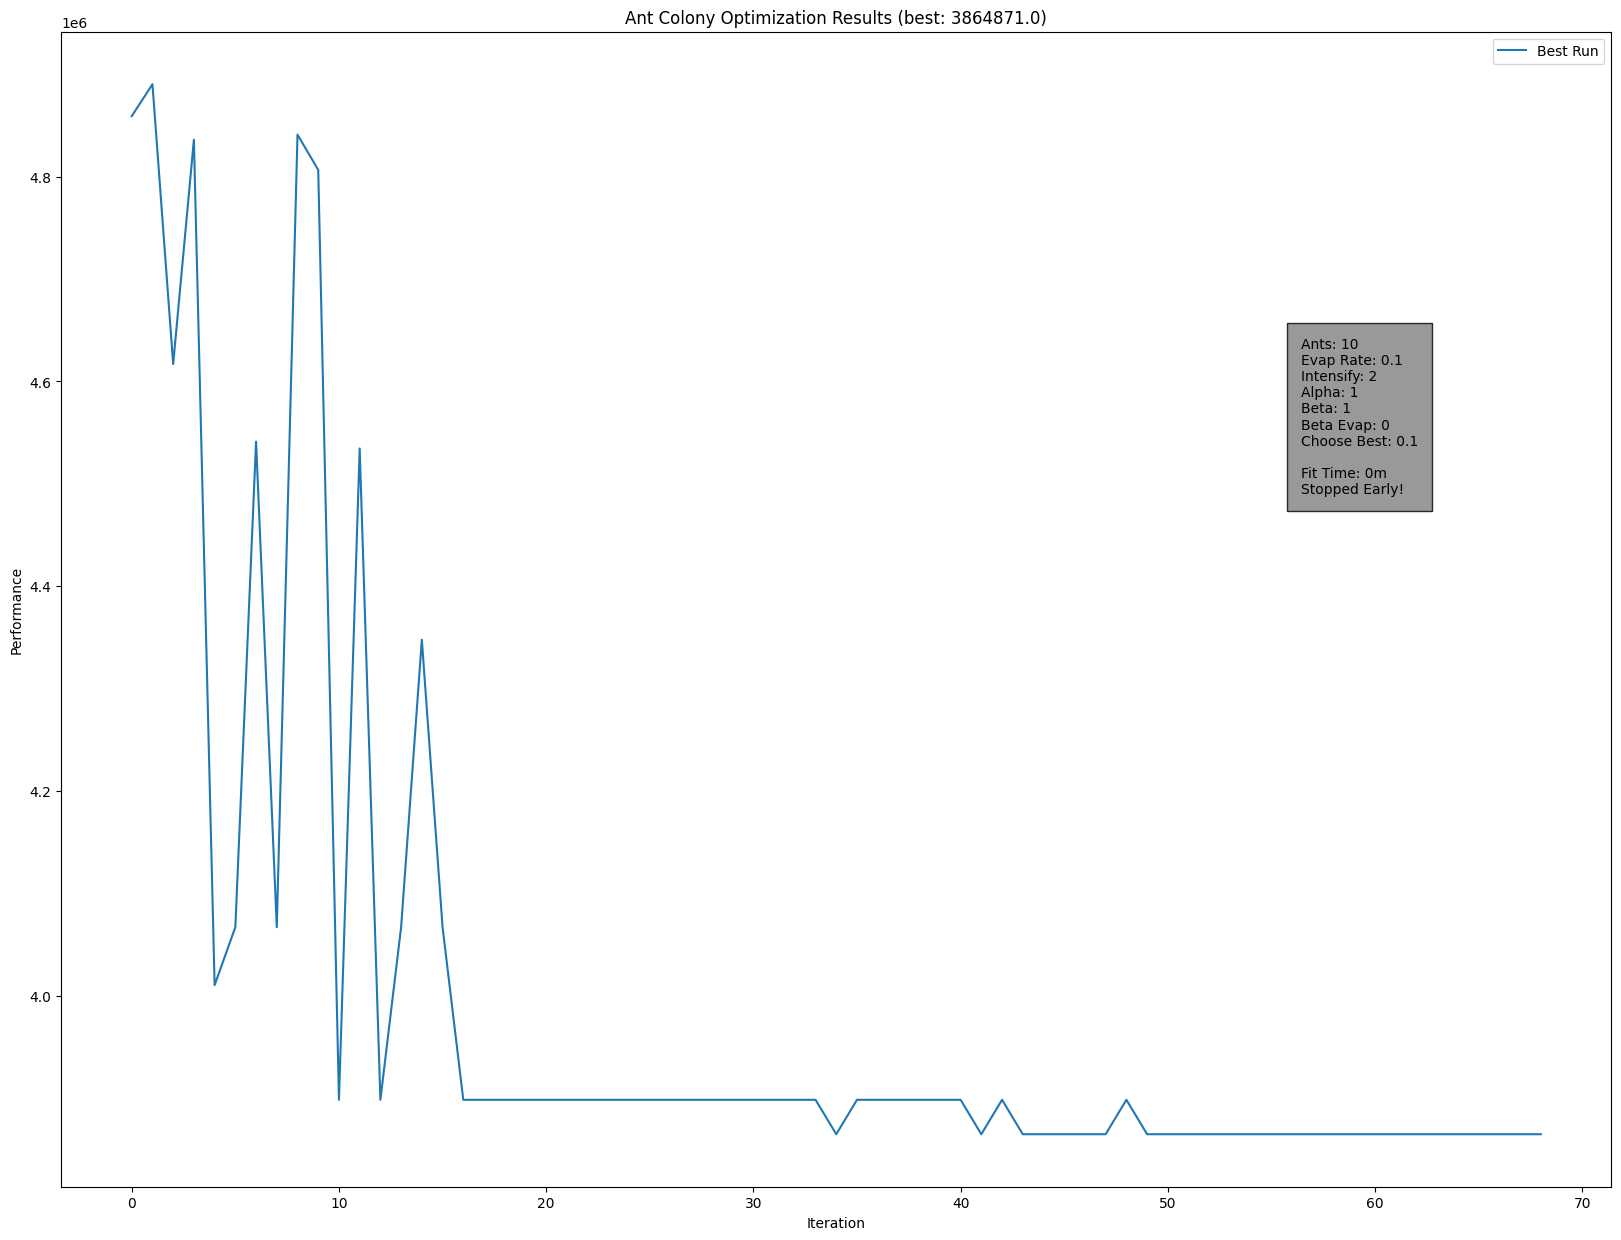

In [ ]:

optimizer = AntColonyOptimizer(ants=10, evaporation_rate=.1, intensification=2, alpha=1, beta=1,
                               beta_evaporation_rate=0, choose_best=.1)

best = optimizer.fit(problem, 100)
optimizer.plot()

##Mejor corrida

In [ ]:
#Muestra el costo mas bajo del ciclo
optimizer.best_path

[13, 14, 7, 9, 11, 10, 8, 12, 2, 0, 1, 5, 4, 6, 3, 13]

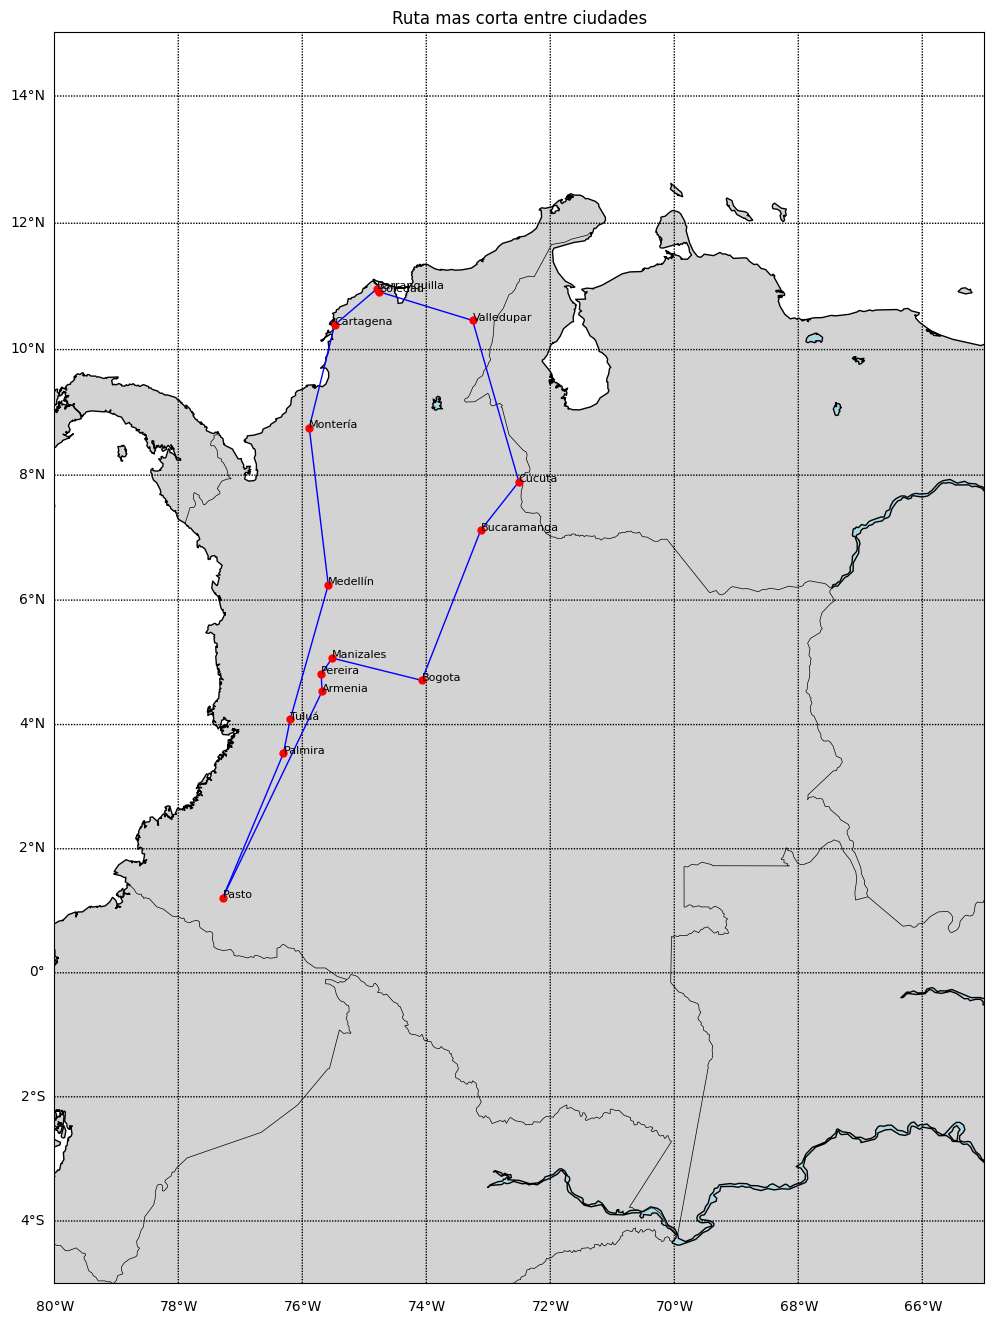

In [ ]:
# Coordenadas de las ciudades
coordenadas = {
    "Palmira": (3.5394, -76.3036),
    "Pasto": (1.2136, -77.2811),
    "Tuluá": (4.0847, -76.1950),
    "Bogota": (4.7109, -74.0721),
    "Pereira": (4.8133, -75.6961),
    "Armenia": (4.5346, -75.6811),
    "Manizales": (5.0689, -75.5174),
    "Valledupar": (10.4631, -73.2533),
    "Montería": (8.7575, -75.8880),
    "Soledad": (10.9184, -74.7649),
    "Cartagena": (10.3910, -75.4794),
    "Barranquilla": (10.9639, -74.7964),
    "Medellín": (6.2442, -75.5812),
    "Bucaramanga": (7.1193, -73.1227),
    "Cúcuta": (7.8939, -72.5071)
}

# Orden de las ciudades
orden_ciudades = optimizer.best_path

# Configuración del mapa
plt.figure(figsize=(12, 25))
m = Basemap(projection='merc', llcrnrlat=-5, urcrnrlat=15, llcrnrlon=-80, urcrnrlon=-65, resolution='i')

# Dibujar las costas, fronteras y países
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='lightgray', lake_color='lightblue')

# Dibujar paralelos y meridianos
m.drawparallels(np.arange(-90., 91., 2.), labels=[True, False, False, True])
m.drawmeridians(np.arange(-180., 181., 2.), labels=[True, False, False, True])

# Dibujar líneas entre los puntos de las ciudades
for i in range(len(orden_ciudades) - 1):
    ciudad_1 = list(coordenadas.keys())[orden_ciudades[i]]
    ciudad_2 = list(coordenadas.keys())[orden_ciudades[i + 1]]
    lat_1, lon_1 = coordenadas[ciudad_1]
    lat_2, lon_2 = coordenadas[ciudad_2]

    # Calcular puntos intermedios
    num_points = 10
    lons = np.linspace(lon_1, lon_2, num_points)
    lats = np.linspace(lat_1, lat_2, num_points)

    x, y = m(lons, lats)
    m.plot(x, y, linewidth=1, color='blue')

# Dibujar los puntos de las ciudades
for ciudad, (lat, lon) in coordenadas.items():
    x, y = m(lon, lat)
    m.plot(x, y, 'ro', markersize=5)
    plt.text(x, y, ciudad, fontsize=8)

plt.title('Ruta mas corta entre ciudades')
plt.show()


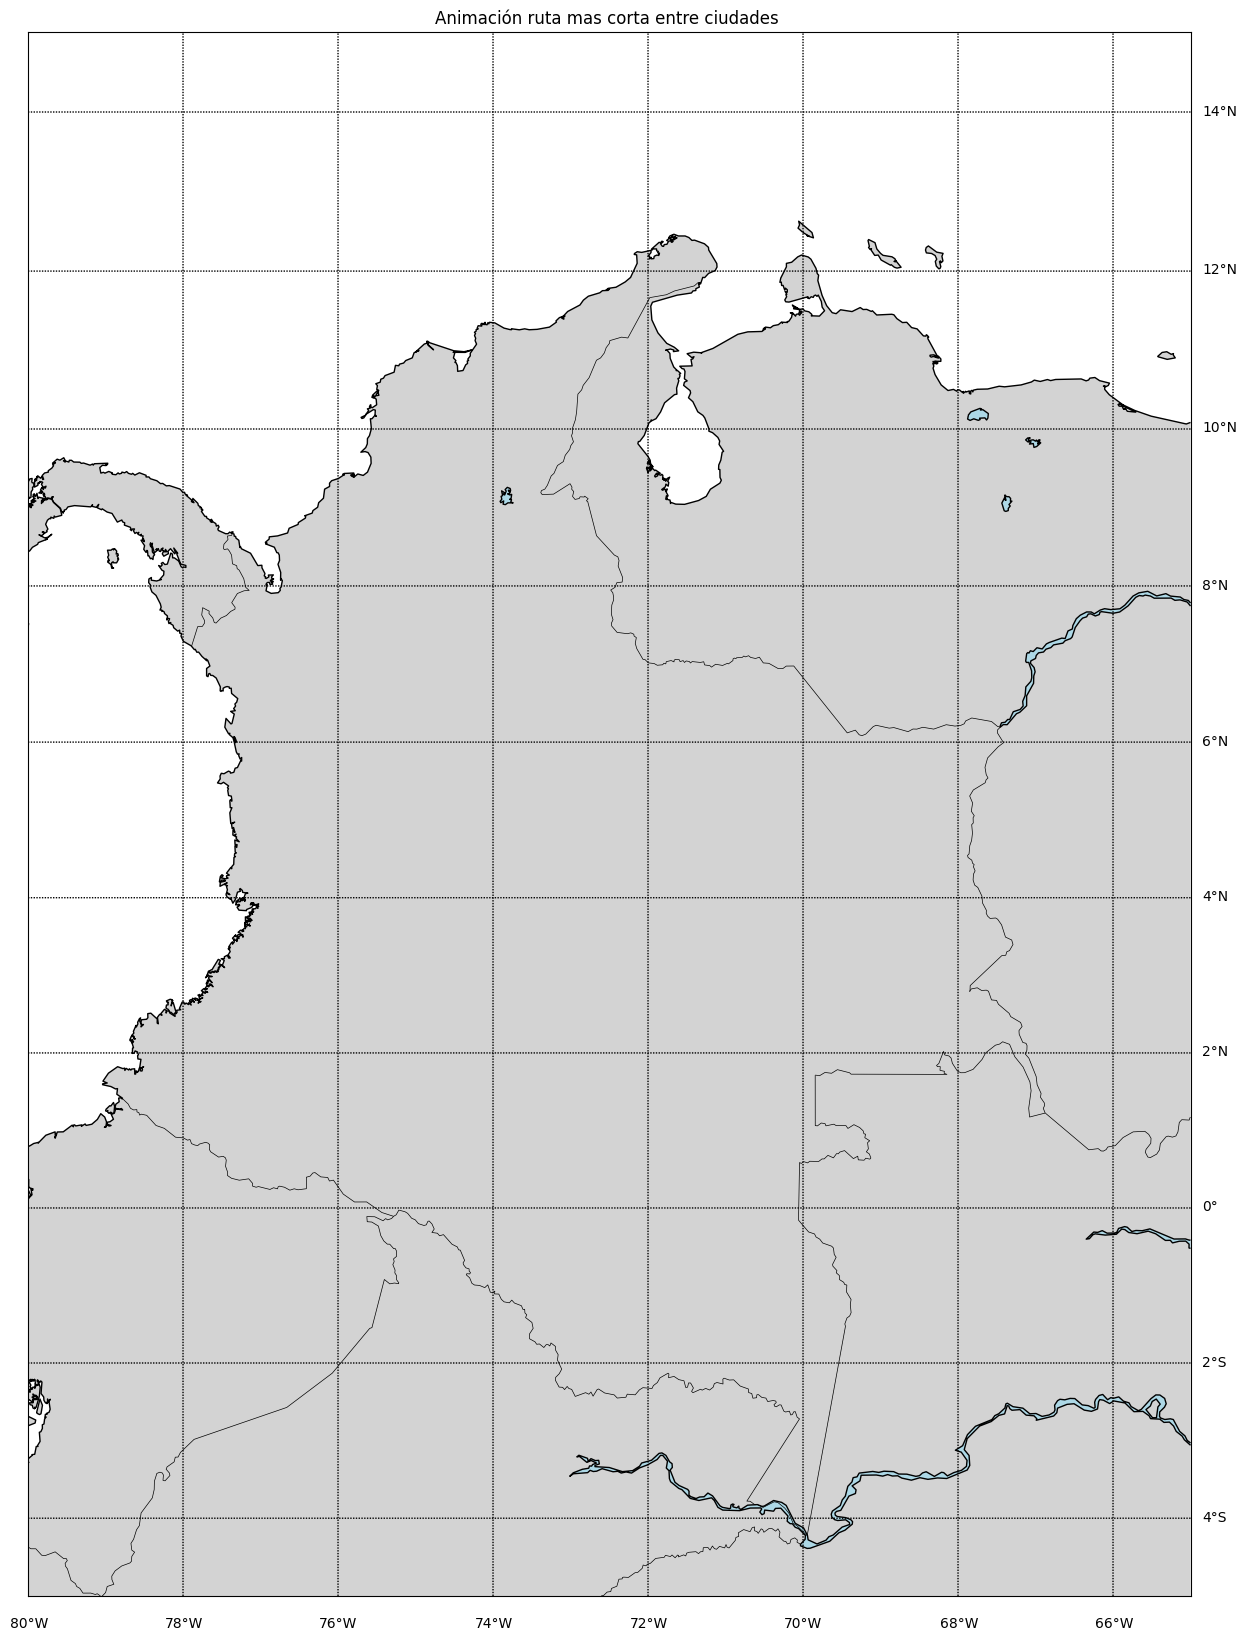

In [ ]:
# Configuración inicial del gráfico
fig = plt.figure(figsize=(15, 25))
ax = fig.add_subplot(111)

# Configuración del mapa
m = Basemap(projection='merc', llcrnrlat=-5, urcrnrlat=15, llcrnrlon=-80, urcrnrlon=-65, resolution='i')

# Dibujar las costas, fronteras y países
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='lightgray', lake_color='lightblue')

# Dibujar paralelos y meridianos
m.drawparallels(range(-90, 91, 2), labels=[False,True,True,False])
m.drawmeridians(range(-180, 181, 2), labels=[True,False,False,True])

# Lista para mantener las líneas trazadas
lines = []

# Función para actualizar la animación
def update(frame):
    if frame > 0:
        ciudad_1 = list(coordenadas.keys())[orden_ciudades[frame - 1]]
        ciudad_2 = list(coordenadas.keys())[orden_ciudades[frame]]
        lat_1, lon_1 = coordenadas[ciudad_1]
        lat_2, lon_2 = coordenadas[ciudad_2]
        lons = [lon_1, lon_2]
        lats = [lat_1, lat_2]
        x, y = m(lons, lats)
        line, = ax.plot(x, y, marker='o', linestyle='-', color='blue', alpha=0.5)
        lines.append(line)
    return lines

# Crear la animación
ani = FuncAnimation(fig, update, frames=len(orden_ciudades), blit=True, repeat=False)

plt.title('Animación ruta mas corta entre ciudades ')
plt.show()


##Bibliografía
https://autolab.com.co/recomendaciones-de-taller/renault/logan/problemas/gasta-mucha-gasolina/<br>
https://es.globalpetrolprices.com/Colombia/gasoline_prices/<br>
https://github.com/johnberroa/Ant-Colony-Optimization<br>

